### HRRR precipitable water spatial spectrum analysis
**Wei-Ming Tsai, Sept 2020**

Doing spectrum analysis for the PW field

- The HRRR is a NOAA real-time 3-km resolution, hourly updated, cloud-resolving, convection-allowing atmospheric model, initialized by 3km grids with 3km radar assimilation. Radar data is assimilated in the HRRR every 15 min over a 1-h period adding further detail to that provided by the hourly data assimilation from the 13km radar-enhanced Rapid Refresh.<br>
<br>
- Using 2D power-spectrum to asesss the dominant horizontal scale of CWV variations

In [2]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import cfgrib
import cf2cdm
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import xarray as xr

from eofs.standard import Eof

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
HRRR_dir = '/data2/willytsai/HRRR_PW_6hourly/'

In [5]:
os.chdir(HRRR_dir)

In [34]:
files=glob('*.grib2')
ds = xr.open_dataset(files[0], engine='cfgrib')
pwat = ds.pwat.values
lon = ds.longitude.values
lat = ds.latitude.values

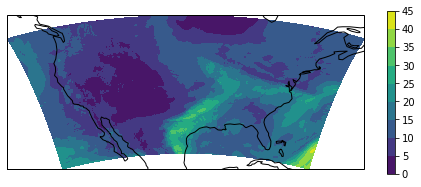

In [35]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = ax.contourf(lon,lat,pwat,transform=ccrs.PlateCarree())
#ax.set_xlim([235,245])
#ax.set_ylim([35,45])
plt.colorbar(cf,shrink=0.5)

In [36]:
# specifying region of interest
idx_s = []; idy_s = []
for i in range(lon.shape[0]):
    for j in range(lon.shape[1]):
        if (lon[i,j] > 235 and lon[i,j] < 245) and (lat[i,j]>35 and lat[i,j]<45):
            idx_s.append(i); idy_s.append(j)

In [37]:
lon_s = lon[np.min(np.asarray(idx_s)):np.max(np.asarray(idx_s)),
              np.min(np.asarray(idy_s)):np.max(np.asarray(idy_s))]

lat_s = lat[np.min(np.asarray(idx_s)):np.max(np.asarray(idx_s)),
              np.min(np.asarray(idy_s)):np.max(np.asarray(idy_s))]

pwat_s = pwat[np.min(np.asarray(idx_s)):np.max(np.asarray(idx_s)),
              np.min(np.asarray(idy_s)):np.max(np.asarray(idy_s))]

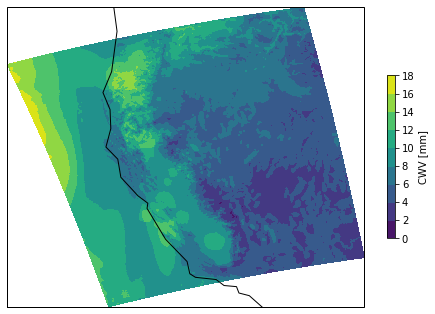

In [38]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = ax.contourf(lon_s,lat_s,pwat_s,transform=ccrs.PlateCarree(),shading='nearest')
cbar = plt.colorbar(cf,shrink=0.5)
cbar.set_label('CWV [mm]')

In [20]:
## constructing half-year data
pwat_com = np.zeros((50,pwat_s.shape[0],pwat_s.shape[1]))
for n in range(50):
    try:
        ds = xr.open_dataset(files[n], engine='cfgrib')
        pwat = ds.pwat.values
        pwat_com[n,:,:] = ds.pwat.values[np.min(np.asarray(idx_s)):np.max(np.asarray(idx_s)),
                  np.min(np.asarray(idy_s)):np.max(np.asarray(idy_s))]
    except:
        pwat_com[n,:,:] = np.nan

### EOF analysis over a western region

In [21]:
pwat_re = pwat_com.reshape((pwat_com.shape[0],pwat_com.shape[1]*pwat_com.shape[2]))

In [59]:
solver=Eof(pwat_re)
eof=solver.eofs(neofs=6); # EOF, spatial structure of SSTA
pc=solver.pcs(npcs=6); # Principle components (PC), a timeseris of amplitude
fra=solver.varianceFraction(neigs=6)*100; # explained variance
print('First 3 EOF:', fra[0:6])
print('shape of eofs:',np.shape(eof))

First 3 EOF: [39.06318508 15.8844203   8.74890111  5.45828831  3.88215096  3.17302772]
shape of eofs: (6, 155428)


In [60]:
eof_re = eof.reshape((6,pwat_s.shape[0],pwat_s.shape[1]))

In [61]:
eof_re[1,:,:].shape

(427, 364)

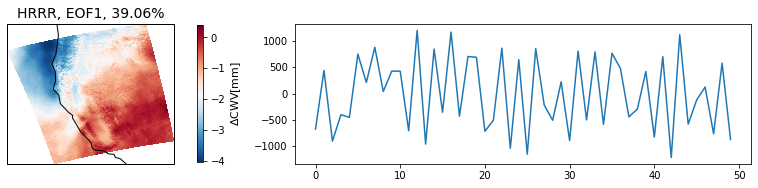

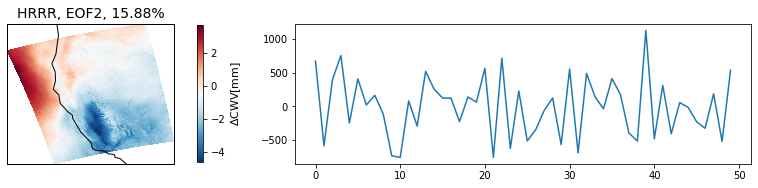

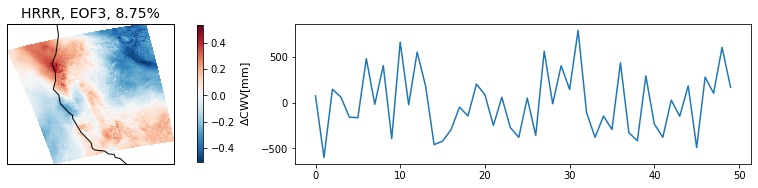

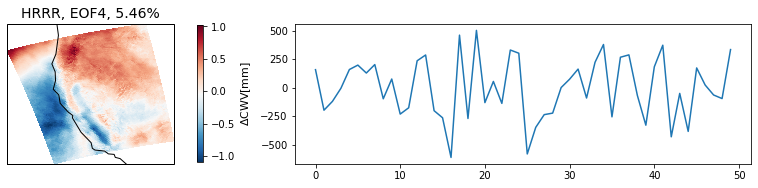

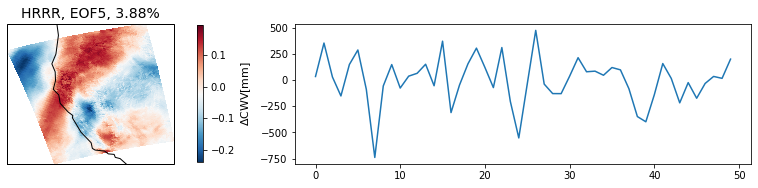

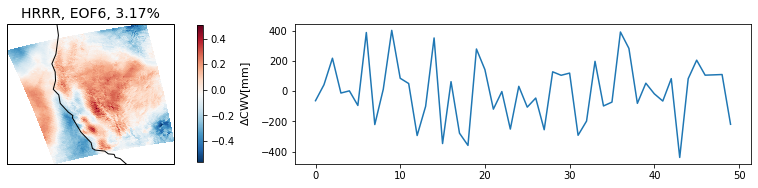

In [64]:
# plot figures 
eofn=6; # select the number of EOFs display

## EOF Display
for n in range(eofn):
    fig=plt.figure(figsize=(18,3*eofn))
    
    ax=fig.add_subplot(eofn,2,2*n+1,projection=ccrs.PlateCarree())
    fill = ax.pcolor(lon_s,lat_s,eof_re[n,:,:].squeeze()*pc[0,n], transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)
    ax.coastlines()
    cb = plt.colorbar(fill,fraction=0.015)
    cb.set_label(r'$\rm\Delta CWV [mm]$', fontsize=11)
    plt.title('HRRR, EOF'+str(n+1)+', '+str(np.round(fra[n],decimals=2))+'%', fontsize=14)
#     plt.xticks(np.linspace(-90,90,7),['120E','150E','180','150W','120W','90W','60W'])
#     plt.yticks(np.linspace(-20,20,5),['20S','10S','EQ','10N','20N'])
    
    ax2=fig.add_subplot(eofn,2,2*n+2)
    plt.plot(pc[:,n])
    #plt.xlim([0,np.size(pwata,0)])
    #plt.xticks(np.linspace(0,420,8),np.int32(np.linspace(1982,2017,8)))
    #plt.ylabel('Amplitude',fontsize=12);plt.title('PC'+str(n+1),fontsize=14)
plt.tight_layout(h_pad=6)
plt.show()

Date: 2019/05/06 06Z

### 2D FFT spectrum analysis
https://github.com/mkolopanis/python/blob/master/radialProfile.py

In [ ]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.
    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [ ]:
from scipy import fftpack
from matplotlib.colors import LogNorm

F1 = fftpack.fft2(pw_100km)
# Now shift the quadrants around so that low spatial frequencies are in
# the center of the 2D fourier transformed image.
F2 = fftpack.fftshift(F1)
psd2D = np.abs(F2)**2
# Calculate the azimuthally averaged 1D power spectrum
psd1D = azimuthalAverage(psd2D)

fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(1,2,1)
c1 = ax1.imshow(psd2D,norm=LogNorm(vmin=10),cmap='jet')
plt.colorbar(c1)
ax1.set_title('2D Power Spectrum')
ax1.set_xlabel('x-dir');ax1.set_ylabel('y-dir')

ax2 = plt.subplot(1,2,2)
ax2.semilogy(psd1D,'-o')
ax2.set_xlabel('Spatial Frequency')
ax2.set_ylabel('Power Spectrum')

In [ ]:
psd1D.shape

In [ ]:
psd1d_cum = np.cumsum(psd1D)/np.sum(psd1D) # cumulative power spectrum
plt.plot(psd1d_cum)
plt.ylabel('Cumulative power')
plt.xlabel('Spatial Frequency')
plt.xlim([0,20])

In [ ]:
pw_cross = pw_100km[10,:]
plt.plot(pw_cross)

In [ ]:
### a 1d example 
# Take the simple FFT, after removing the mean

V = pw_cross; NT = len(V)
Vp = V - V.mean()
Vspec = np.fft.fft( Vp )

# It is symmetric, with low frequencies at BOTH ENDS, except 0 (the mean)
fig,ax=plt.subplots(1,1) 
ax.plot(Vspec.real)
#ax.plot(Vspec.imag)

In [ ]:
# Define the frequencies "freqs" (noting the symmetry -- but 0 occurs only at left)

freqs = np.array(range(NT))   # This gets the left end correct
reversed_freqs = freqs[::-1]  # Reverse the array 
reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
freqs = reversed_freqs[::-1]  # reverse it back 

In [ ]:
# Complex conjugate does the squaring
Power = (Vspec.conjugate()*Vspec).real
Power *= np.var(Vp) / Power.sum()       # Enforce Parseval's theorem for variance 
fig,ax=plt.subplots(2,1,figsize=(6,6)) 
ax[0].stem(freqs, Power)
ax[0].set_xlim([0,18])
ax[0].set_xlabel('Frequency (cycles per length-of-record)')
ax[0].set_ylabel('Power variance density')
ax[0].set_title('100 km cross-section')

print('Variance is', Vp.var(), '(m/s)^2: matches', sum(Power))


ax[1].plot(np.cumsum(Power)/sum(Power))
ax[1].set_ylabel('Cumulative variance')
ax[1].set_xlabel('Frequency (cycles per length-of-record)')
plt.tight_layout()